In [124]:
# Import Required Libraries
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [125]:
# Load the dataset
df = pd.read_csv('/content/diabetes.csv')

# Display the first few rows
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Check dataset information
print(df.info())

# Check class distribution
print(df['Outcome'].value_counts())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
<class 'pandas.core.

In [126]:
# Replace zeros with median values
columns_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in columns_to_replace:
    df[col] = df[col].replace(0, df[col].median())

In [127]:
# Feature Engineering
# Age Groups
df['AgeGroup'] = pd.cut(df['Age'], bins=[20, 30, 40, 50, 60, 100], labels=['20-30', '30-40', '40-50', '50-60', '60+'])

# BMI Categories
df['BMICategory'] = pd.cut(df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Glucose Levels
df['GlucoseLevel'] = pd.cut(df['Glucose'], bins=[0, 99, 125, 200, 300], labels=['Normal', 'Prediabetes', 'Diabetes', 'Severe Diabetes'])

In [128]:
# Define the ordinal categories in the correct order
age_categories = ['20-30', '30-40', '40-50', '50-60', '60+']
bmi_categories = ['Underweight', 'Normal', 'Overweight', 'Obese']
glucose_categories = ['Normal', 'Prediabetes', 'Diabetes', 'Severe Diabetes']

In [129]:
# Initialize OrdinalEncoder
encoder = OrdinalEncoder(categories=[age_categories, bmi_categories, glucose_categories])

# Apply encoding
df[['AgeGroup', 'BMICategory', 'GlucoseLevel']] = encoder.fit_transform(df[['AgeGroup', 'BMICategory', 'GlucoseLevel']])

# Convert to integer type for better readability
df[['AgeGroup', 'BMICategory', 'GlucoseLevel']] = df[['AgeGroup', 'BMICategory', 'GlucoseLevel']].astype(int)

# Display the updated DataFrame
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeGroup,BMICategory,GlucoseLevel
0,6,148,72,35,30.5,33.6,0.627,50,1,2,3,2
1,1,85,66,29,30.5,26.6,0.351,31,0,1,2,0
2,8,183,64,23,30.5,23.3,0.672,32,1,1,1,2
3,1,89,66,23,94.0,28.1,0.167,21,0,0,2,0
4,0,137,40,35,168.0,43.1,2.288,33,1,1,3,2


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
 9   AgeGroup                  768 non-null    int64  
 10  BMICategory               768 non-null    int64  
 11  GlucoseLevel              768 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 72.1 KB


In [131]:
# Encode Categorical Features
# df = pd.get_dummies(df, columns=['AgeGroup', 'BMICategory', 'GlucoseLevel'], drop_first=True)

In [132]:
# Identify outliers using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()
print("Outliers per feature:")
print(outliers)

Outliers per feature:
Pregnancies                  4
Glucose                      0
BloodPressure               14
SkinThickness               35
Insulin                     49
BMI                          8
DiabetesPedigreeFunction    29
Age                          9
Outcome                      0
AgeGroup                     0
BMICategory                  4
GlucoseLevel                 0
dtype: int64


In [133]:
# Removing outliers by capping extreme values
data = df.apply(lambda x: np.where(x > x.quantile(0.99), x.quantile(0.99), x))
data = df.apply(lambda x: np.where(x < x.quantile(0.01), x.quantile(0.01), x))

In [134]:
#Split Features and Target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

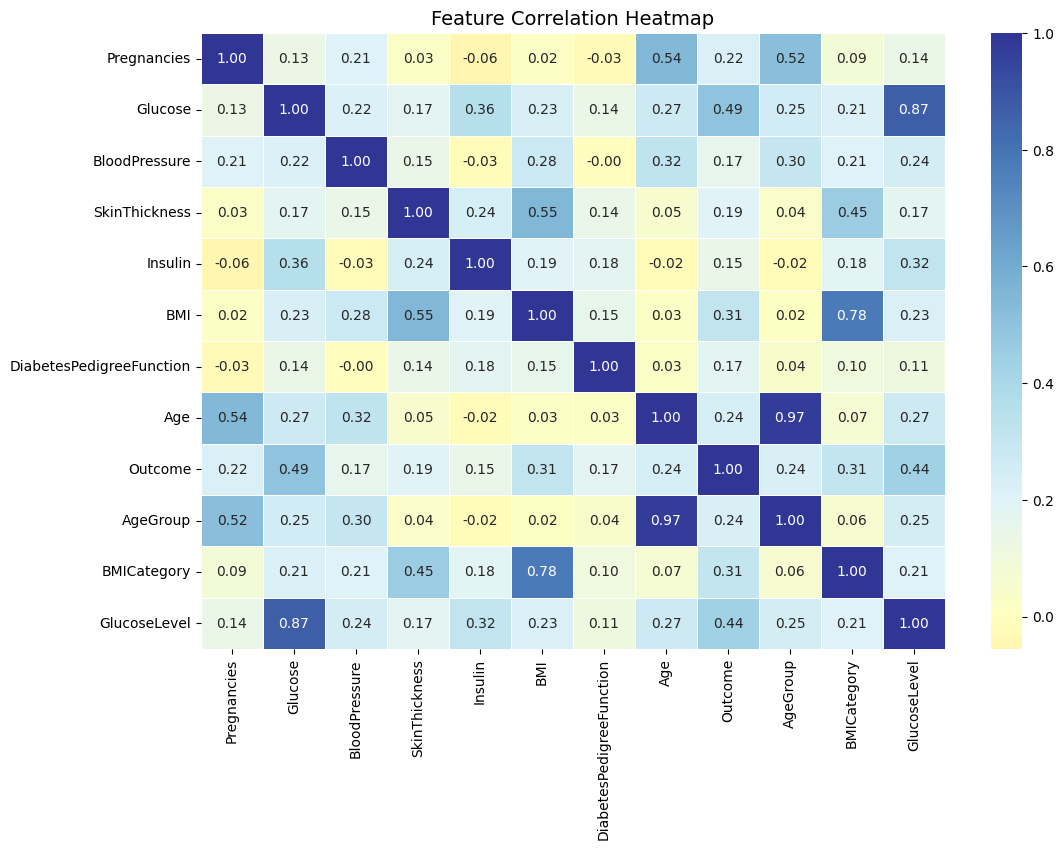

In [135]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="RdYlBu", center=0, fmt=".2f", linewidths=0.5, annot_kws={"size": 10})
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()


In [136]:
# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=8)
X = selector.fit_transform(X, y)

In [137]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X, y = smote.fit_resample(X, y)

In [138]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

In [139]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [140]:
# Train SVM Model
# Baseline SVM Model
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train)

# Predict on test set
y_pred = svm.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline SVM Accuracy: {accuracy:.2f}")

Baseline SVM Accuracy: 0.80


In [141]:
# Hyperparameter Tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear','poly','sigmoid'],
    'degree': [2,3,4]
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train model with best parameters
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Tuned SVM Accuracy: {accuracy:.2f}")

Best Parameters: {'C': 10, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
Tuned SVM Accuracy: 0.81


In [146]:
train_accuracy = best_svm.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.2f}")

Training Accuracy: 0.83


In [142]:
# Cross-Validation
cv_scores = cross_val_score(best_svm, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} (±{cv_scores.std():.2f})")

Cross-Validation Accuracy: 0.80 (±0.07)


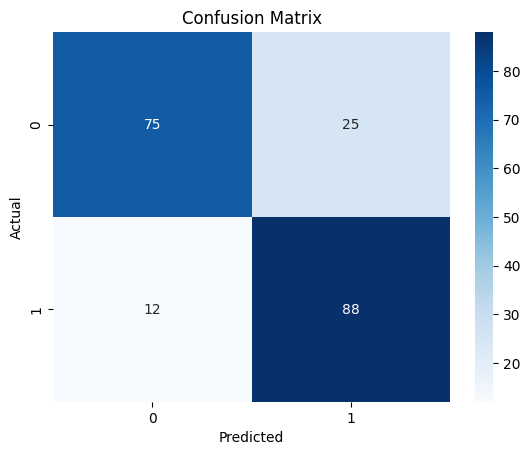

In [143]:
# Evaluate Model Performance
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [144]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80       100
           1       0.78      0.88      0.83       100

    accuracy                           0.81       200
   macro avg       0.82      0.81      0.81       200
weighted avg       0.82      0.81      0.81       200



In [145]:
# Final Model
import joblib
joblib.dump(best_svm, 'diabetes_svm_model.pkl')

['diabetes_svm_model.pkl']